# **Basic Graph Neural Network with Spectral Graph Convolution on MNIST**

## **Libraries**

In [1]:
from torch.utils.data.dataset import Subset
from scipy.spatial.distance import cdist
from torch.utils.data import DataLoader
from scipy.sparse.linalg import eigsh
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [3]:
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
RANDOM_SEED = 1
LEARNING_RATE = 0.05
NUM_EPOCHS = 10
BATCH_SIZE = 128
IMG_SIZE = 28

In [5]:
NUM_CLASSES = 10

## **MNIST Dataset**

In [6]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

In [7]:
custom_transform = transforms.Compose([transforms.ToTensor()])

In [8]:
train_and_valid = datasets.MNIST(root='data', train=True, transform=custom_transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=custom_transform, download=True)

In [9]:
train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [11]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Model**

In [12]:
def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
    dist = cdist(coord, coord, metric='euclidean')
    sigma = 0.05 * np.pi
    A = np.exp(- dist / sigma ** 2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()
    return A

In [13]:
def get_graph_laplacian(A):
    N = A.shape[0] 
    D = np.sum(A, 0)
    D_hat = np.diag((D + 1e-5)**(-0.5))
    L = np.identity(N) - np.dot(D_hat, A).dot(D_hat) 
    return torch.from_numpy(L).float()

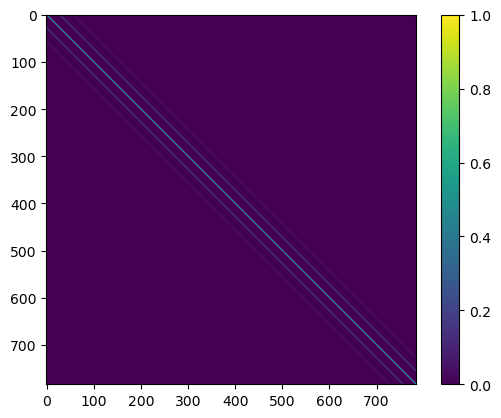

In [14]:
A = precompute_adjacency_matrix(28)
plt.imshow(A, vmin=0., vmax=1.)
plt.colorbar()
plt.show()

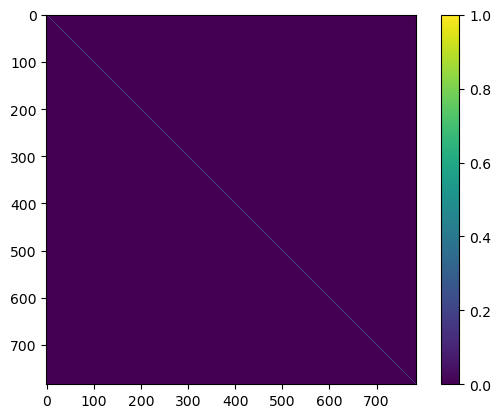

In [15]:
L = get_graph_laplacian(A.numpy())
plt.imshow(L, vmin=0., vmax=1.)
plt.colorbar()
plt.show()

In [16]:
class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_filters=2, num_classes=10):
        super(GraphNet, self).__init__()
        
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows*num_filters, num_classes, bias=False)

        A = precompute_adjacency_matrix(img_size)
        L = get_graph_laplacian(A.numpy())
        Λ,V = eigsh(L.numpy(), k=20, which='SM') 
        V = torch.from_numpy(V)
        
        W_spectral = nn.Parameter(torch.ones((img_size**2, num_filters))).float()
        torch.nn.init.kaiming_uniform_(W_spectral)
        
        self.register_buffer('A', A)
        self.register_buffer('L', L)
        self.register_buffer('V', V)
        self.register_buffer('W_spectral', W_spectral)

    def forward(self, x):
        
        B = x.size(0)
        V_tensor = self.V.unsqueeze(0)
        V_tensor = self.V.expand(B, -1, -1)
        V_tensor_T = self.V.T.unsqueeze(0)
        V_tensor_T = self.V.T.expand(B, -1, -1)
        
        x_reshape = x.view(B, -1, 1)
        
        W_spectral_tensor = self.W_spectral.unsqueeze(0)
        W_spectral_tensor = self.W_spectral.expand(B, -1, -1)
        
        X_hat = V_tensor_T.bmm(x_reshape) 
        W_hat = V_tensor_T.bmm(W_spectral_tensor)  
        Y = V_tensor.bmm(X_hat * W_hat) 

        logits = self.fc(Y.reshape(B, -1))
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [17]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

In [18]:
model = model.to(DEVICE)

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

## **Training phase**

In [20]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [21]:
start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        optimizer.step()
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    model.eval()
    with torch.set_grad_enabled(False):
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60

Epoch: 001/010 | Batch 000/461 | Cost: 2.3310
Epoch: 001/010 | Batch 150/461 | Cost: 1.2220
Epoch: 001/010 | Batch 300/461 | Cost: 0.9917
Epoch: 001/010 | Batch 450/461 | Cost: 0.8765
Epoch: 001/010
Train ACC: 75.53 | Validation ACC: 80.50
Time elapsed: 0.26 min
Epoch: 002/010 | Batch 000/461 | Cost: 0.8875
Epoch: 002/010 | Batch 150/461 | Cost: 0.7952
Epoch: 002/010 | Batch 300/461 | Cost: 0.6480
Epoch: 002/010 | Batch 450/461 | Cost: 0.8647
Epoch: 002/010
Train ACC: 77.29 | Validation ACC: 81.20
Time elapsed: 0.51 min
Epoch: 003/010 | Batch 000/461 | Cost: 0.8382
Epoch: 003/010 | Batch 150/461 | Cost: 0.8349
Epoch: 003/010 | Batch 300/461 | Cost: 1.0795
Epoch: 003/010 | Batch 450/461 | Cost: 0.8952
Epoch: 003/010
Train ACC: 78.41 | Validation ACC: 82.70
Time elapsed: 0.76 min
Epoch: 004/010 | Batch 000/461 | Cost: 0.7133
Epoch: 004/010 | Batch 150/461 | Cost: 0.6563
Epoch: 004/010 | Batch 300/461 | Cost: 0.7669
Epoch: 004/010 | Batch 450/461 | Cost: 0.8481
Epoch: 004/010
Train ACC: 7

In [22]:
print(f'Total Training Time: {elapsed:.2f} min')

Total Training Time: 2.56 min


## **Evaluation**

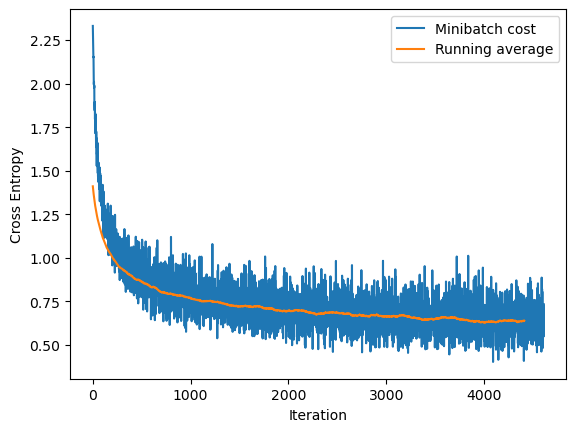

In [23]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, np.ones(200,)/200, mode='valid'), label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

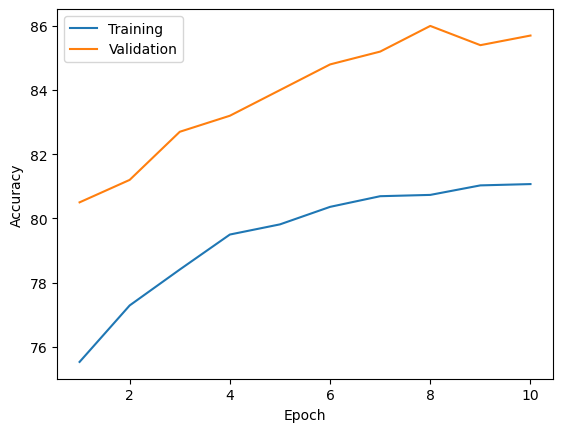

In [24]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 85.70%
Test ACC: 82.37%
